<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/06_transfer_learning_in_tensorflow-part3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With TensorFlow Part 3: Scaling Up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101(101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training ( leveraging the power of deep learning).

Original Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jul 19 03:25:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we've created a series of helper functions to do different tasks, let's download them



In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-25 19:33:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-25 19:33:09 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper funcitons for our notebook
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the `image_data_modification` notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-07-25 19:33:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   186MB/s    in 6.9s    

2021-07-25 19:33:18 (226 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


In [5]:
# How many images/classes are there?
walk_through_dir(dir_path="101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10

In [6]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE= (224, 224)
BATCH_SIZE=32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")
# Not Shuffle the test data for prediction analysis
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take :
* Create a ModelCheckpoint callback
* Create data augmentation layer to build data augmentation right into model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model ( we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [ ]:
# Create  checkpoint callback

checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,                                                          
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True,
                                                          save_freq="epoch")


In [7]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
              preprocessing.RandomFlip("horizontal"),
              preprocessing.RandomRotation(0.2),
              preprocessing.RandomHeight(0.2),
              preprocessing.RandomWidth(0.2),
              preprocessing.RandomZoom(0.2),
              #preprocessing.Rescaling(1/255.), # rescale inputs of images to between 0 & 1, required for model like ResNet50              
            ], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers(this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup  model architectures with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs) # augment images (only happens during the training phase)

x = base_model(x, training = False) # put the base model in inference mode, so weights which need to stay frozen, stay frozen

x = layers.GlobalAvgPool2D(name="global_avg_pool_layer")(x)

# For layers, the inputs or x goes outside. For model it can go inside 
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer") (x)

model = tf.keras.Model(inputs, outputs)


16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile our model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent, 
                                           epochs=5, # fit for epochs to keep experiment quick
                                           validation_data = test_data,
                                           validation_steps = int(0.15 *len(test_data)), # validate on only 15% of the data during training
                                           callbacks=[checkpoint_callback])

In [ ]:
# Evaluate the model
feature_extraction_results = model.evaluate(test_data)


790/790 [==============================] - 91s 115ms/step - loss: 1.7183 - accuracy: 0.5527


[1.7183185815811157, 0.5527128577232361]

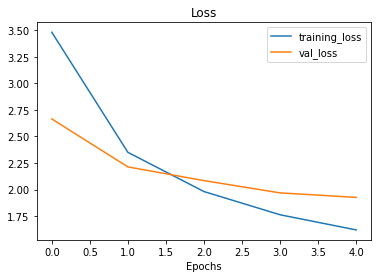

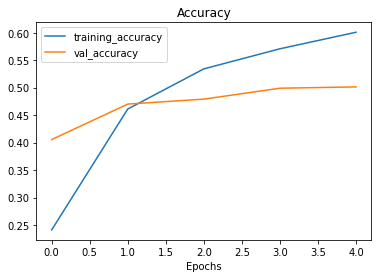

In [ ]:
# Plot loss curves
plot_loss_curves(history_all_classes_10_percent)

> **Question** : What do these curves suggest? 
Hint : ideally, the two curves should be very similar to each other, it not...

> **Answer** : Our model is overfitting as seen above, val_loss and val_accuracy deviating from training curves.

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5] :
  layer.trainable = False


In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10%
              metrics=["accuracy"])

In [ ]:
# what layers in model are trainable ?
for layer in model.layers :
  print(layer.name, layer.trainable)


input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check with layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fit the model for another 5 more epochs
fine_tune_epochs = 10 # Model has already done 5 epochs(feature extraction), this is total number of epochs we'are after (5 + 5 = 10)

# Fine-tune our models
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 66s 249ms/step - loss: 1.2664 - accuracy: 0.6709 - val_loss: 1.9242 - val_accuracy: 0.5003
Epoch 6/10
237/237 [==============================] - 56s 234ms/step - loss: 1.1540 - accuracy: 0.6968 - val_loss: 1.9042 - val_accuracy: 0.5135
Epoch 7/10
237/237 [==============================] - 55s 229ms/step - loss: 1.0882 - accuracy: 0.7118 - val_loss: 1.9308 - val_accuracy: 0.5103
Epoch 8/10
237/237 [==============================] - 54s 225ms/step - loss: 1.0080 - accuracy: 0.7270 - val_loss: 1.9259 - val_accuracy: 0.5130
Epoch 9/10
237/237 [==============================] - 52s 218ms/step - loss: 0.9542 - accuracy: 0.7447 - val_loss: 1.8980 - val_accuracy: 0.5204
Epoch 10/10
237/237 [==============================] - 51s 214ms/step - loss: 0.8998 - accuracy: 0.7593 - val_loss: 1.9227 - val_accuracy: 0.5156


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 92s 116ms/step - loss: 1.6270 - accuracy: 0.5768


[1.6269607543945312, 0.5767524838447571]

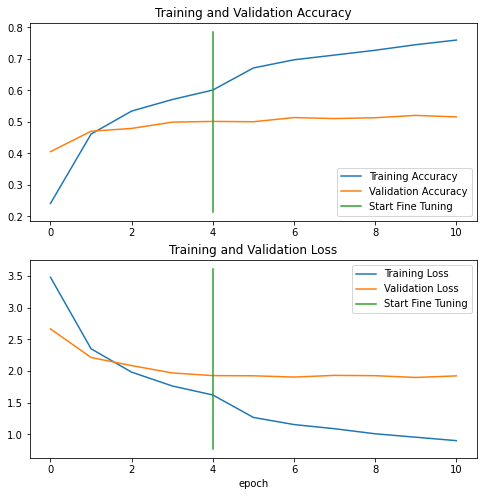

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history= history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and Loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Save our fine-tuning model
# Save it to your google drive
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

NameError: ignored

In [10]:
# Load an evaluated saved model
# Read from google drive
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [11]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 125s 119ms/step - loss: 1.6270 - accuracy: 0.5768


[1.6269607543945312, 0.5767524838447571]

In [12]:
# The results from our loaded model(above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

NameError: ignored

## Evaluating the performance of th ebig model across all different classes

Let's make some predictions, visualize them and later find out which predictions were wrong 

In [13]:
# Download pretrained model (one we trained earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-25 19:37:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   171MB/s    in 0.3s    

2021-07-25 19:37:46 (171 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [14]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [15]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [16]:
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [17]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model
#[1.6269607543945312, 0.5767524838447571]

790/790 [==============================] - 95s 119ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making a prediction with our trained model

In [18]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 66s 82ms/step


In [19]:
len(test_data), 790*32
# 25250 test images so with  batch size of 32, its 790 batches


(790, 25280)

In [20]:
# How many predictions are there
len(preds_probs)

25250

In [21]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [22]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542004e-02, 3.5742048e-06, 4.1376974e-02, ..., 1.4138707e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780657e-04, ..., 5.4286997e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925879e-01, 3.2533586e-05, 1.4866921e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275969e-05],
       ...,
       [4.7313261e-01, 1.2931220e-07, 1.4805585e-03, ..., 5.9750013e-04,
        6.6969093e-05, 2.3469209e-05],
       [4.4571821e-02, 4.7265530e-07, 1.2258515e-01, ..., 6.3498514e-06,
        7.5318521e-06, 3.6778734e-03],
       [7.2438997e-01, 1.9249742e-09, 5.2310865e-05, ..., 1.2291356e-03,
        1.5792692e-09, 9.6395699e-05]], dtype=float32)

In [23]:
# What does first prediction probability looks like
len(preds_probs[0]), sum(preds_probs[0]), preds_probs[0]

(101,
 1.0000000121530062,
 array([5.95420040e-02, 3.57420481e-06, 4.13769744e-02, 1.06605957e-09,
        8.16144308e-09, 8.66396554e-09, 8.09270432e-07, 8.56525787e-07,
        1.98590351e-05, 8.09776793e-07, 3.17278026e-09, 9.86737405e-07,
        2.85321876e-04, 7.80491949e-10, 7.42302276e-04, 3.89165252e-05,
        6.47403658e-06, 2.49773507e-06, 3.78911318e-05, 2.06783668e-07,
        1.55384660e-05, 8.15070223e-07, 2.62305161e-06, 2.00107237e-07,
        8.38273706e-07, 5.42161388e-06, 3.73908892e-06, 1.31505820e-08,
        2.77614570e-03, 2.80519434e-05, 6.85626778e-10, 2.55748546e-05,
        1.66889280e-04, 7.64068475e-10, 4.04528779e-04, 1.31506335e-08,
        1.79573601e-06, 1.44482021e-06, 2.30628569e-02, 8.24668518e-07,
        8.53658491e-07, 1.71386603e-06, 7.05251614e-06, 1.84022007e-08,
        2.85533758e-07, 7.94834523e-06, 2.06815321e-06, 1.85251167e-07,
        3.36197701e-08, 3.15225829e-04, 1.04109231e-05, 8.54482778e-07,
        8.47418606e-01, 1.05554454e-0

Our model outputs a prediction probability array(with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [24]:
# We get one prediction probability per class (in our case there's 101 prediction probability)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 : {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420040e-02 3.57420481e-06 4.13769744e-02 1.06605957e-09
 8.16144308e-09 8.66396554e-09 8.09270432e-07 8.56525787e-07
 1.98590351e-05 8.09776793e-07 3.17278026e-09 9.86737405e-07
 2.85321876e-04 7.80491949e-10 7.42302276e-04 3.89165252e-05
 6.47403658e-06 2.49773507e-06 3.78911318e-05 2.06783668e-07
 1.55384660e-05 8.15070223e-07 2.62305161e-06 2.00107237e-07
 8.38273706e-07 5.42161388e-06 3.73908892e-06 1.31505820e-08
 2.77614570e-03 2.80519434e-05 6.85626778e-10 2.55748546e-05
 1.66889280e-04 7.64068475e-10 4.04528779e-04 1.31506335e-08
 1.79573601e-06 1.44482021e-06 2.30628569e-02 8.24668518e-07
 8.53658491e-07 1.71386603e-06 7.05251614e-06 1.84022007e-08
 2.85533758e-07 7.94834523e-06 2.06815321e-06 1.85251167e-07
 3.36197701e-08 3.15225829e-04 1.04109231e-05 8.54482778e-07
 8.47418606e-01 1.05554454e-05 4.40946224e-07 3.74043229e-05
 3.53062278e-05 3.24891298e-05 6.73148679e-

In [25]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [26]:
# How many pred classes do we have ?
len(pred_classes)

25250

Now we've got a prediction array of all of our model's predictions, to evaluate them, we need to compare them to the original dataset labels.

In [27]:
# to get our test labels we need to unravel our test_data BatchDataset

y_labels=[]
for images, labels in test_data.unbatch() :
  y_labels.append(labels.numpy().argmax()) # currently test labels look like : [0, 0, 0, 1...,0, 0] we want the index value where "1" occurs

y_labels[:10] # Look at the first 10
# They are all index 0 since we didnt shuffled(Shuffle=False) test_data , so they are in order

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
# How many y_labels are there?
len(y_labels)

25250

In [29]:
# y_labels from test_data and pred_classes from prediction are in same order and of size 25250

## Evaluating model's predictions
One way to check that our model's predictions arrays in the same order as our test labels array is to find the accuracy score.

In [30]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [31]:
# Let's try scikit-learn accuracy score function and see what is comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels, 
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [32]:
# Does this metric come close to our model's evaluate results

import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: Making a confusion matrix

In [33]:
from helper_functions import make_confusion_matrix

In [34]:
# Get list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [35]:
# We need to make some changes to our make_confusion_matrix to ensure the x-labels print vertically
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

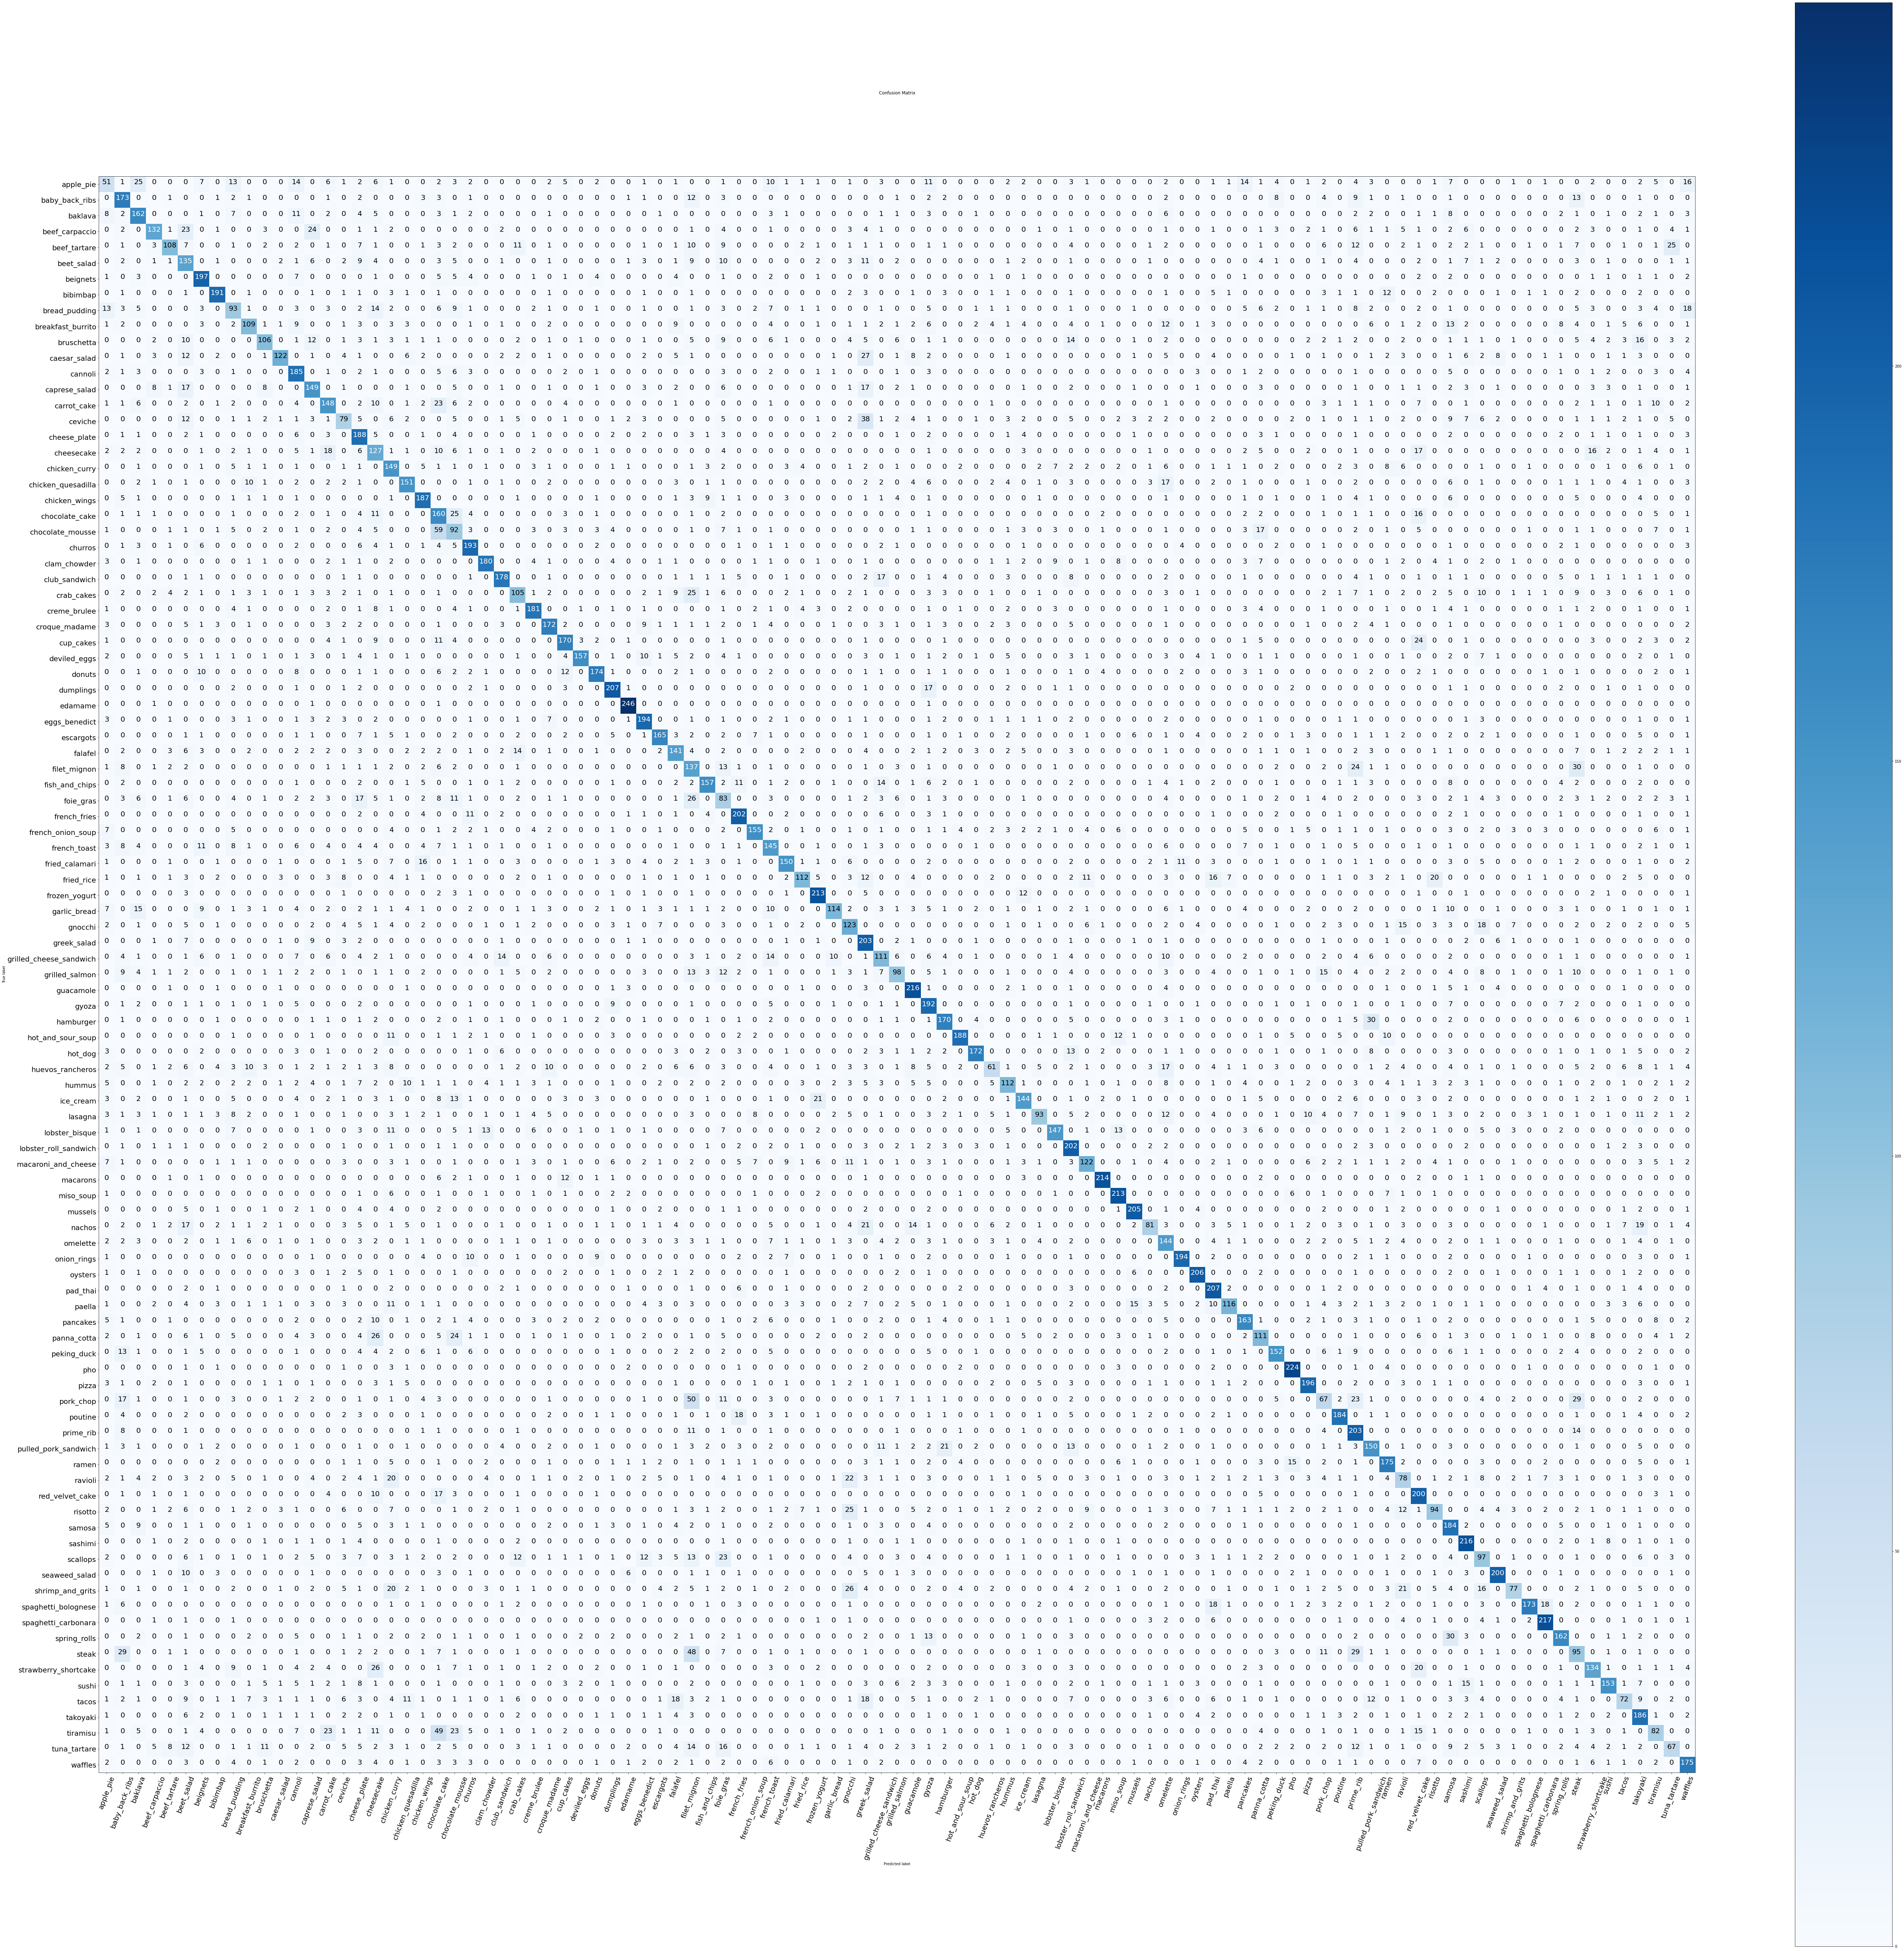

In [36]:
make_confusion_matrix(y_true=y_labels,
                      y_pred = pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,  
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class(e.g. precision, recall, F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).
Let's explore that...

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true= y_labels, 
                            y_pred=pred_classes,
                                                       
                            ))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a class-by-class evaluation of our model's prediction but with so many classes, they're quite hard to understand.

How about we create a visualizationt to get a better understanding?

In [38]:
# Get a dictionary of classification report.
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred = pred_classes,
                                                   output_dict=True
                                                   )
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let's plot all of our classes F1-scores...

In [39]:
# Create empty dictionary
class_f1_scores = {}

# Loop thru classification report dictionary items
for k, v in classification_report_dict.items() :
  if k == "accuracy" : # stop once we get to accruacy key
    break
  else :
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [40]:
# Turn f1-scores into dataframes for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names" : list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores
                         

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


In [41]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


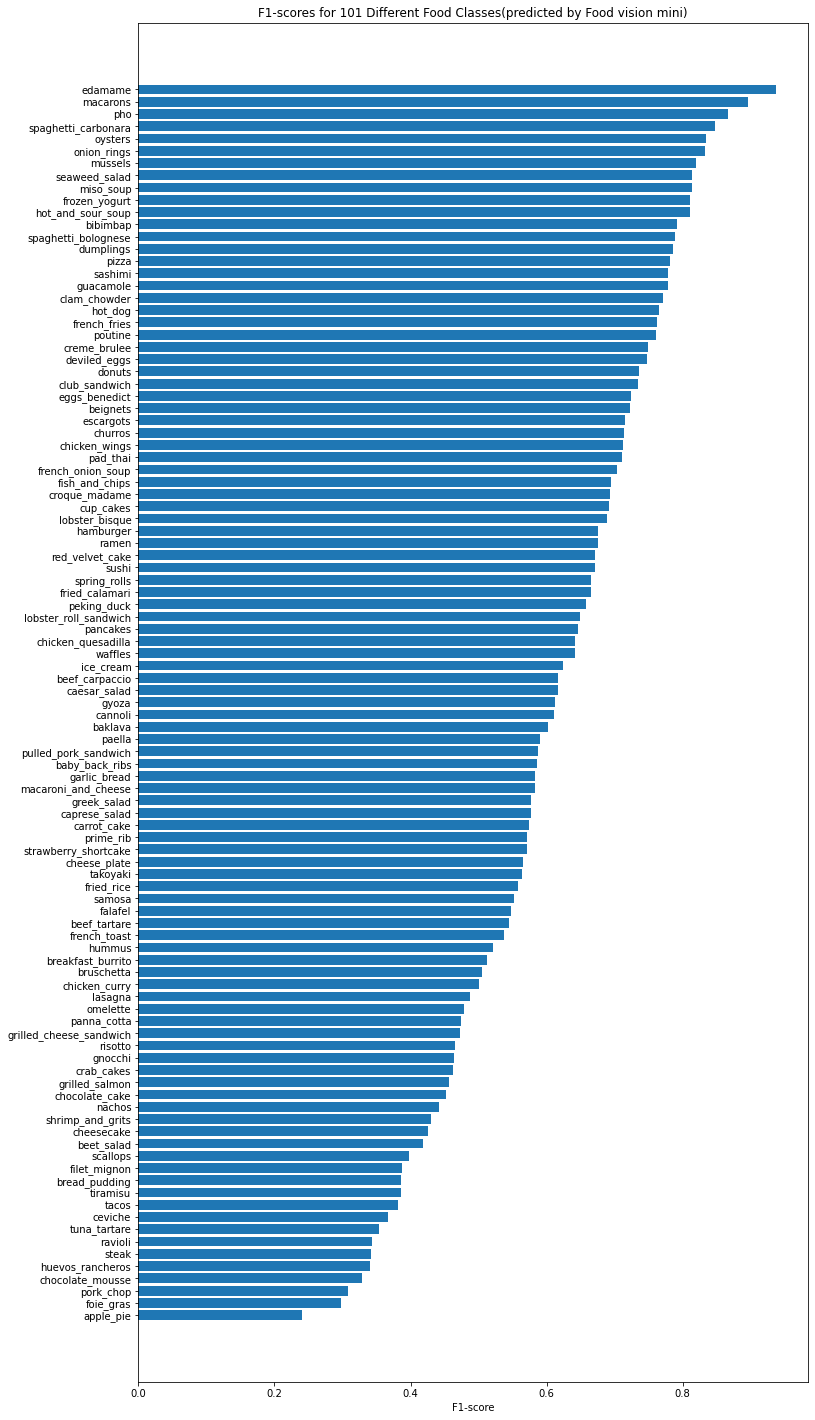

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes(predicted by Food vision mini)")
ax.invert_yaxis(); #Reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint : use the "autolabel" function from here : https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)


> **Exercise** :  Try visualizing some of the most poorly predicted classes(e.g. `apple_pie, pork_chop`), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on custom images

Now this is the real test, how does our model goes on food images not even in our dataset(images of our own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to :
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)


In [51]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True) :
  """
  Reads in an image from filenae, turns it into a tensor and reshapes into specified shape
  (img_shape, img_shape, color_channels = 3).

  Args:
    filename (str) : path to target image
    image_shape(int) : height/width dimension of target image size
    scale(bool) : scale pixel values from 0-255 to 0-1 or not
  
  Returns :
    Image tensor of shape(img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale ? Yes/no
  if scale :
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else :
    return img # don't need to rescale images for EfficientNet models in TensorFlow

  


 Now we've got a function to load and prepare target images, 
 let's now write some code to visualize images, their target label and our model's predictions.

 Specifically, we'll write some code to :
 1. Load a few random images from the test dataset
 2. Make predictios on the loaded images
 3. Plot the original images(s) along with the model's predictions, prediction probability and truth label
 

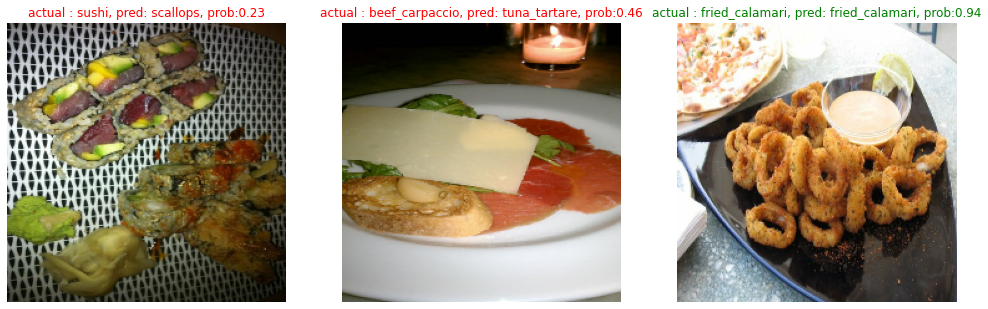

In [72]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3) :
  # Choose a random image from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  #Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  #print (img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to class_name list
  #print(pred_prob)
  #print(pred_class)

  #Plot the images(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class : # if predicted classes matches truth class, make it green
    title_color = "g"
  else :
    title_color = "r"

  plt.title(f"actual : {class_name}, pred: {pred_class}, prob:{pred_prob.max():.2f}", c=title_color)
  plt.axis(False);
